# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** \
**Email:**

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

### Todo
#### Part 1.

Step1: Split (by speaker IDs)

Train: ~80 speakers
Validation (dev): ~10 speakers
Test: ~10 speakers
Key rule:
Each speaker (their ID) must appear in exactly one split — if a speaker’s recordings are in Train, none of their samples can appear in Validation or Test.
Otherwise, the model would “hear” that person’s voice during training and the evaluation would be biased.


Step 2: Stratification / coverage guardrails

Because we’re predicting 44 phoneme classes, we want to make sure each split has good coverage of all 44 phones.
Some phonemes may be rare.
If we randomly split by speaker, our validation/test speakers might not pronounce every phoneme enough times.
So we can do group-stratified splitting — a smart split that tries to match the overall distribution of phonemes (how often each phone appears) across train/val/test.
If any phone ends up too rare in validation/test (say < 20 examples), redraw the split or adjust the proportions slightly (for example, Train 78 / Val 12 / Test 10 speakers).

Step 3: Sessions / days

If each speaker recorded across multiple days, keep all of their days together in one split.
We don’t want Day 1 in training and Day 2 in testing — because it’s still the same speaker, which would break the “new speaker” rule.


Step 4: Preprocessing discipline (avoid leakage)

To make sure our evaluation is fair:
Compute any normalization statistics (e.g., mean/variance for features, MFCC normalization, etc.) only using the training speakers.
Apply those same parameters to validation/test.
Don’t peek at validation/test data when computing data augmentations, vocabulary, or feature scaling.
This prevents “data leakage” — subtle information about the test set leaking into the model.


Step 5: Metrics:

Report macro-averaged accuracy/F1 over the 44 phones (so rare phones matter), plus per-phone confusion for error analysis.







#### Part 2.

Step 1: Evaluation Sets (so we can measure both goals)

To check performance on both fronts, we now keep two test sets:
Purpose	      Dataset	                                  Description
Generic Test	same 10 held-out speakers from Part 1	    measures how well we generalize to new people overall
Kilian Test	  a subset of Kilian’s 10 000 recordings    measures how well we perform on this speaker
              (never seen during training)	            

We split Kilian’s 10 000 like this:

Kilian-Train: 70 % → used for model adaptation
Kilian-Dev: 15 % → used to tune/early-stop during adaptation
Kilian-Test: 15 % → final evaluation (held out)

If his data are recorded on different days, sessions, or devices, keep those entire sessions separate — e.g., Train on Day 1-4, Test on Day 5 — to avoid nearly identical samples in train and test.

If not, we can just do a temporal or chunk-based split (e.g., first 70 % train | next 15 % dev | final 15 % test).



Step 2: Training Strategy

Multi-domain Mixed Fine-tuning:
Start from our base model trained on the 100 speakers.
During fine-tuning, mix Kilian’s data with some generic training data: for example, 80 % Kilian + 20 % Generic per batch.
This way, the model learns Kilian’s voice but still “remembers” others.
Stop training when performance stops improving on Kilian-Dev,
but keep monitoring the Generic-Dev set so generalization doesn’t drop too much.
Outcome: Great improvement on Kilian, small (if any) drop on others.



Step 3: Normalization & Features

Keep the same global feature normalization (mean/variance) we computed from the multi-speaker training set.
Optionally, learn a small Kilian-specific normalization layer (a simple affine transform) that is used only for him — helps adjust for his microphone/voice timbre.



Step 4: Sampling & Class Balance

Because some phonemes may appear more often in Kilian’s speech, we must avoid bias:
Within Kilian’s batches, balance phoneme counts or use class-balanced loss.
When mixing with generic data, ensure both datasets still have reasonable phone coverage.



Step 5: Final Evaluation / Reporting

We’ll now report two main results:

Metric	Dataset	Purpose
Kilian-Test Accuracy/F1	15 % held-out Kilian data	how well we’ve adapted to Kilian
Generic-Test Accuracy/F1	original 10 speakers from Part 1	how well we’ve preserved generalization

We can also experiment with different mix ratios (60:40, 80:20, 90:10) and plot a trade-off curve — to find the “sweet spot” where Kilian’s performance improves a lot while generic performance barely drops.





### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


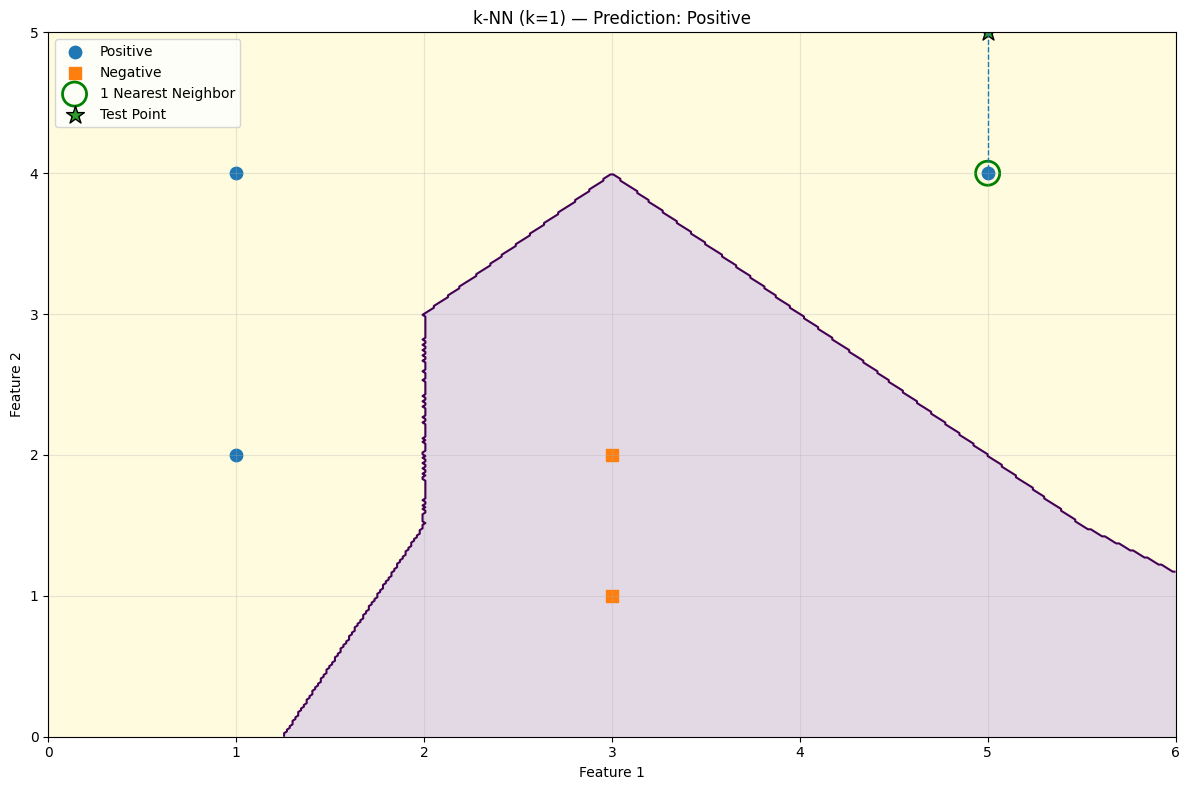

=== BEFORE SCALING ===
Nearest neighbor: [500   4] with label 1
Predicted class: Positive
Distance: 3.00

=== AFTER SCALING ===
Nearest neighbor: [300   1] (scaled: [0.5 0. ]) with label 0
Predicted class: Negative
Distance: 0.50


In [ ]:
# Part 1:
import numpy as np
import matplotlib.pyplot as plt

X_train_pos = np.array([[1,2], [1,4], [5,4]])
X_train_neg = np.array([[3,1], [3,2]])
X_train = np.vstack([X_train_pos, X_train_neg])
Y_train = np.array([1]*3 + [0]*2)  # 1=Positive, 0=Negative

def visualize_knn(k, test_point):
    test_point = np.asarray(test_point).reshape(1, 2)

    # --- 1) k-NN prediction for the test point ---
    distances = np.sqrt(np.sum((X_train - test_point)**2, axis=1))
    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = Y_train[nearest_indices]
    prediction = 1 if np.sum(nearest_labels) > k/2 else 0
    pred_name = 'Positive' if prediction == 1 else 'Negative'

    # --- 2) Build a grid and classify each grid cell (to draw decision regions) ---
    pad = 1.0
    x_min, x_max = X_train[:,0].min()-pad, X_train[:,0].max()+pad
    y_min, y_max = X_train[:,1].min()-pad, X_train[:,1].max()+pad

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]           # (N,2)
    # 1-NN: label of closest training point
    # compute squared distances efficiently
    a2 = np.sum(grid**2, axis=1, keepdims=True)    # (N,1)
    b2 = np.sum(X_train**2, axis=1, keepdims=True).T  # (1,M)
    ab = grid @ X_train.T                          # (N,M)
    sq_dists = a2 + b2 - 2*ab
    nn_idx = np.argmin(sq_dists, axis=1)           # (N,)
    Z = Y_train[nn_idx].reshape(xx.shape)          # decision region labels

    # --- 3) Plot ---
    plt.figure(figsize=(12, 8))
    # decision regions + boundary
    plt.pcolormesh(xx, yy, Z, shading="nearest", alpha=0.15)
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=1.5)

    # training points
    pos_mask = Y_train == 1
    plt.scatter(X_train[pos_mask,0], X_train[pos_mask,1], s=80, marker='o', label='Positive')
    plt.scatter(X_train[~pos_mask,0], X_train[~pos_mask,1], s=80, marker='s', label='Negative')

    # highlight k-NN
    plt.scatter(X_train[nearest_indices,0], X_train[nearest_indices,1],
                s=300, facecolors='none', edgecolors='green', linewidths=2,
                label=f'{k} Nearest Neighbor{"s" if k>1 else ""}')

    # test point + line to nearest
    plt.scatter(test_point[0,0], test_point[0,1], s=180, marker='*', edgecolors='black', label='Test Point')
    for idx in nearest_indices:
        plt.plot([test_point[0,0], X_train[idx,0]],
                 [test_point[0,1], X_train[idx,1]], linestyle='--', linewidth=1)

    plt.title(f'k-NN (k={k}) — Prediction: {pred_name}')
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
    plt.legend(loc='upper left'); plt.grid(True, alpha=0.3)
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
    plt.tight_layout(); plt.show()

visualize_knn(k=1, test_point=[5,5])



# Part 2:
from sklearn.preprocessing import MinMaxScaler

# Dataset
X_train_pos = np.array([[100, 2],
                        [100, 4],
                        [500, 4]])
X_train_neg = np.array([[300, 1],
                        [300, 2]])

X_train = np.vstack([X_train_pos, X_train_neg])
y_train = np.array([1]*3 + [0]*2)   # 1 = Positive, 0 = Negative

# Test point
x_test = np.array([[500, 1]])

# Define a simple 1-NN classifier
def predict_1nn(X, y, x_test):
    distances = np.sqrt(np.sum((X - x_test)**2, axis=1))
    nearest_idx = np.argmin(distances)
    return int(y[nearest_idx]), nearest_idx, distances[nearest_idx]

# Before scaling
pred_before, idx_before, dist_before = predict_1nn(X_train, y_train, x_test)
print("=== BEFORE SCALING ===")
print(f"Nearest neighbor: {X_train[idx_before]} with label {y_train[idx_before]}")
print(f"Predicted class: {'Positive' if pred_before == 1 else 'Negative'}")
print(f"Distance: {dist_before:.2f}\n")

# Scale features to [0,1] per feature
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(x_test)

# After scaling
pred_after, idx_after, dist_after = predict_1nn(X_train_scaled, y_train, x_test_scaled)
print("=== AFTER SCALING ===")
print(f"Nearest neighbor: {X_train[idx_after]} (scaled: {X_train_scaled[idx_after]}) with label {y_train[idx_after]}")
print(f"Predicted class: {'Positive' if pred_after == 1 else 'Negative'}")
print(f"Distance: {dist_after:.2f}")




# Part 3: Compute distance on overlapping features only 

# For each neighbor, use only the dimensions that are present in both the test point and that training sample.
# Normalize by the number of compared features so distances stay comparable.



# Part 4:
# Why k-NN can still work for images:
# 1. Images lie on a structured, low-dimensional manifold
# 2. Distances in embedding space capture visual similarity
# 3. Dense sampling provides meaningful neighbors
# 4. Small changes in pixels/embeddings → small perceptual changes

### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

In [ ]:
#Todo
# Part 1:
# Evaluating h(x)=sign(w⋅x) on both datasets simply computes predictions — it doesn’t inherently tell you why test error might be higher. You can only observe that the test error (on unseen data) may exceed training error due to limited generalization.

# Part 2:
# In the perceptron algorithm, training error need not be computed explicitly because the training process already ensures that all training points are correctly classified at convergence (training error = 0 for separable data).

### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [23]:
# Todo
import numpy as np

# Data
X = np.array([[10, -2],   # +1
              [12,  2]])  # -1
y = np.array([+1, -1])    # labels
lr = 1.0

def perceptron_no_bias(X, y, w0=None, lr=1.0, max_epochs=100):
    w = np.zeros(X.shape[1]) if w0 is None else np.array(w0, dtype=float)
    seq = [w.copy()]
    updates = 0

    for _ in range(max_epochs):
        mistakes = 0
        for xi, yi in zip(X, y):
            if yi * np.dot(w, xi) <= 0:   # mistake -> update
                w = w + lr * yi * xi
                updates += 1
                mistakes += 1
                seq.append(w.copy())
        if mistakes == 0:                 # converged
            break
    return w, updates, seq

w_final, total_updates, seq = perceptron_no_bias(X, y, w0=[0,0], lr=1.0)

print("Final w:", w_final)
print("Total updates:", total_updates)
print("Sequence:")
for i, w in enumerate(seq):
    print(f"w_{i} = {tuple(w)}")


Final w: [  2. -18.]
Total updates: 9
Sequence:
w_0 = (0.0, 0.0)
w_1 = (10.0, -2.0)
w_2 = (-2.0, -4.0)
w_3 = (8.0, -6.0)
w_4 = (-4.0, -8.0)
w_5 = (6.0, -10.0)
w_6 = (-6.0, -12.0)
w_7 = (4.0, -14.0)
w_8 = (-8.0, -16.0)
w_9 = (2.0, -18.0)


### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [25]:
#Todo

# Update log: (x, y, count)
updates = [
    ((0, 0, 0, 0, 4), +1, 2),
    ((0, 0, 6, 5, 0), +1, 1),
    ((3, 0, 0, 0, 0), -1, 1),
    ((0, 9, 3, 6, 0), -1, 1),
    ((0, 1, 0, 2, 5), -1, 1),
]

w = np.zeros(5, dtype=int)  # w0 = (0,0,0,0,0), lr=1
for x, y, c in updates:
    w += c * y * np.array(x)

print("Final weight vector w:", tuple(w))


Final weight vector w: (-3, -10, 3, -3, 3)


### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

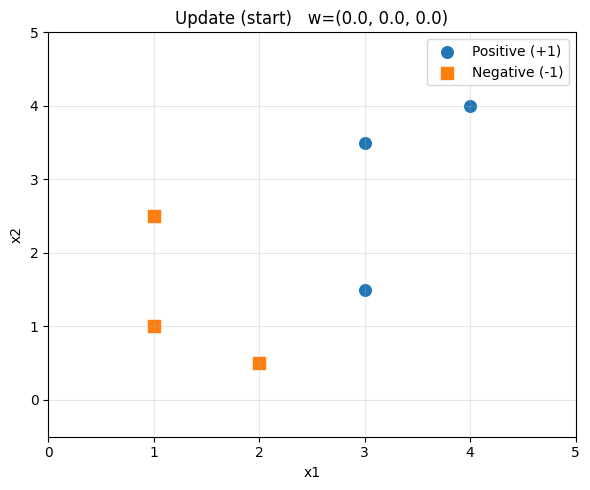

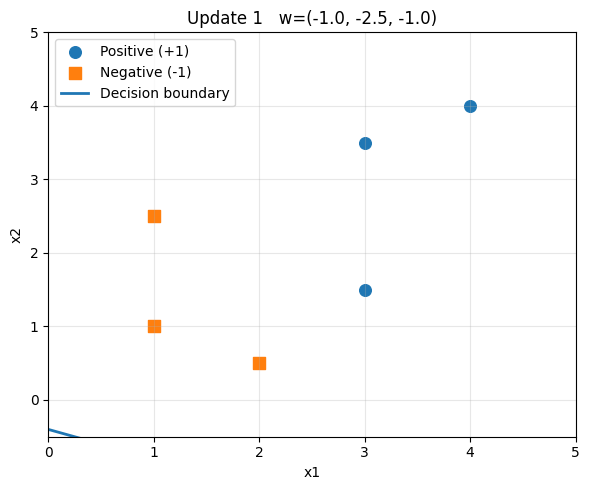

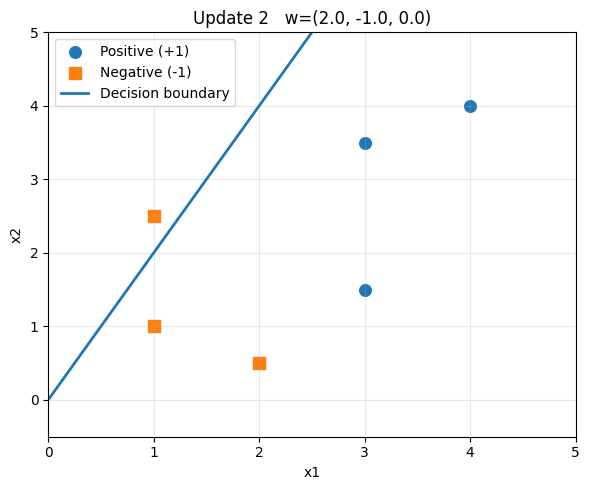

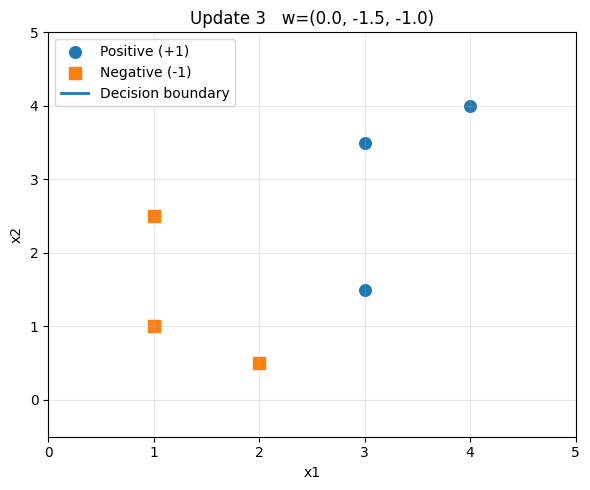

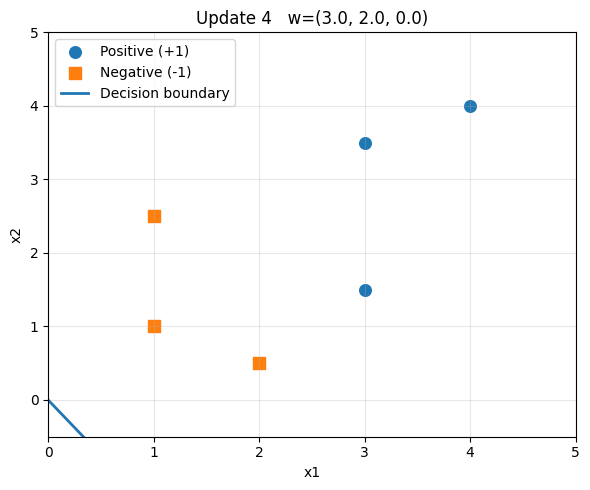

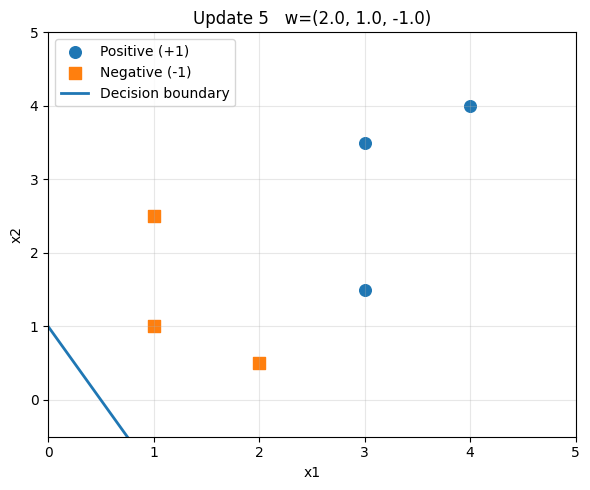

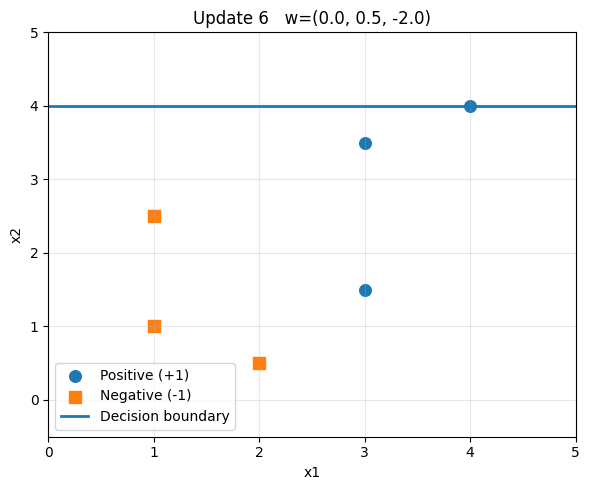

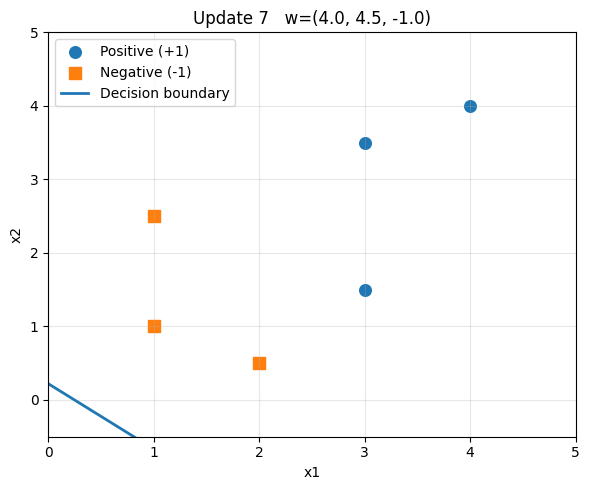

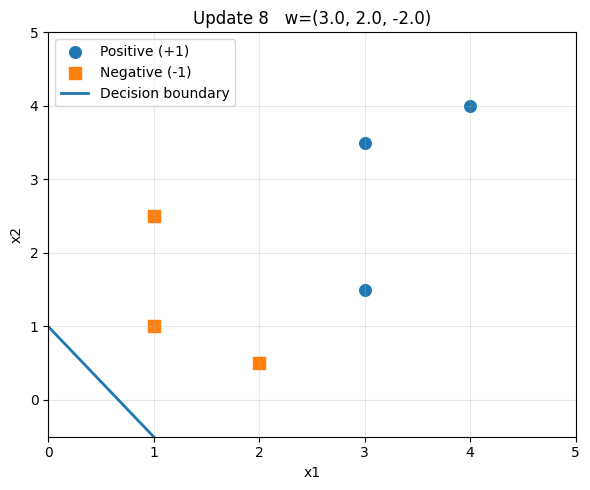

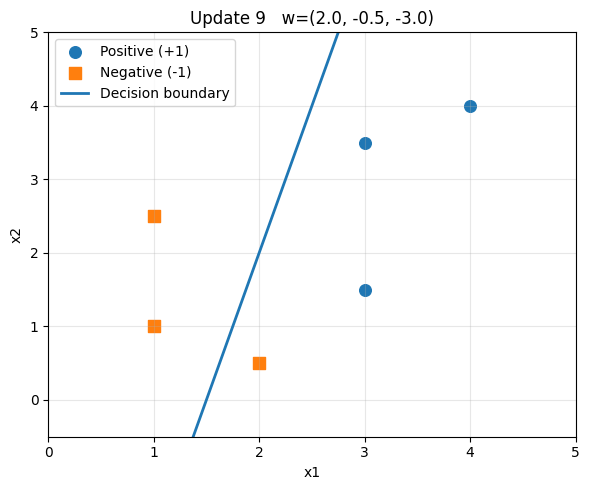

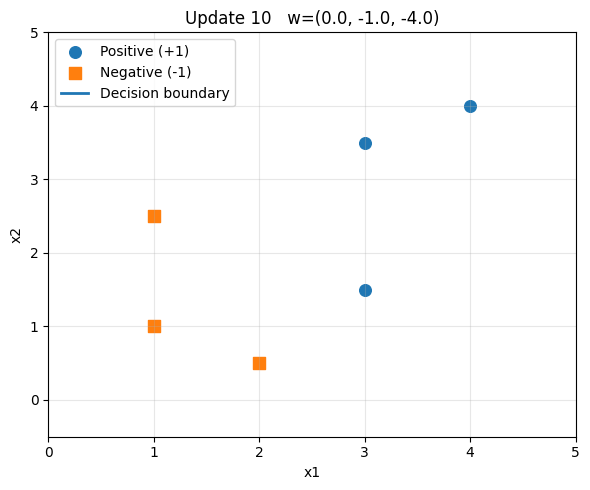

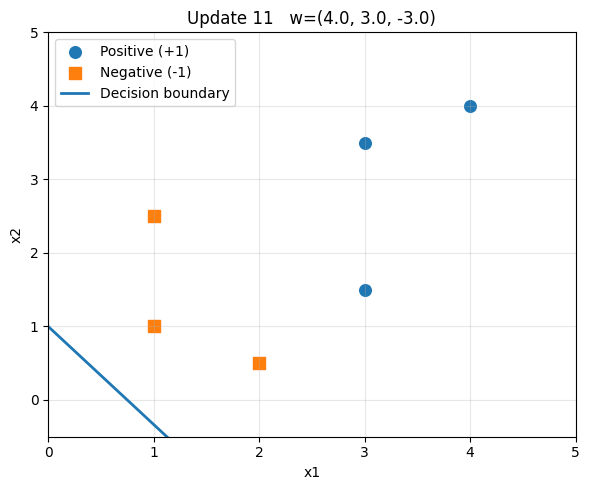

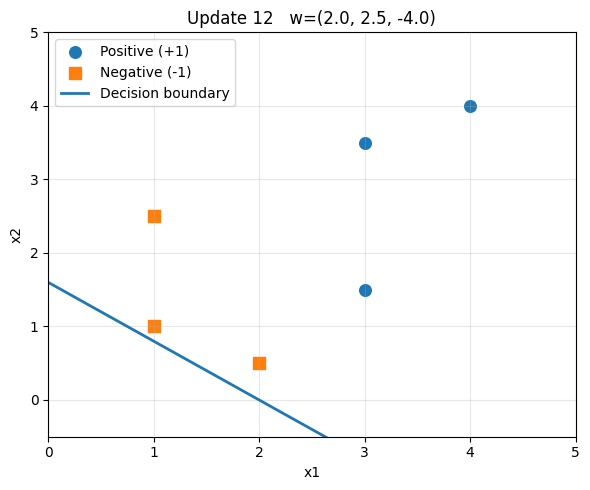

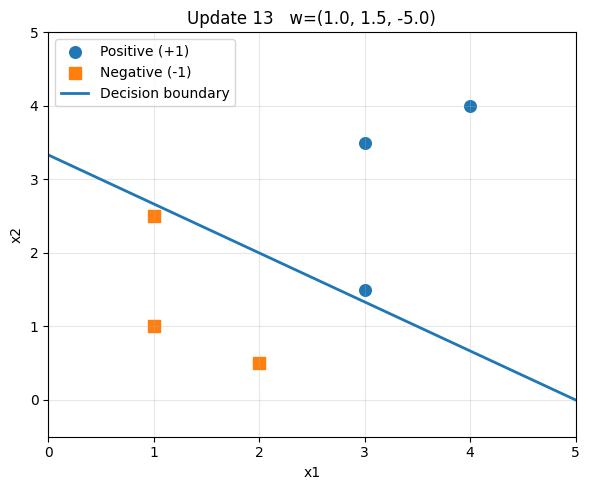

Converged: True | Updates: 13 | Final w: (1.0, 1.5, -5.0)


In [27]:
#Todo

# Separable dataset (tweaked to avoid points lying exactly on the boundary)
X_pos = np.array([[3.0, 3.5],
                  [4.0, 4.0],
                  [3.0, 1.5]])
X_neg = np.array([[1.0, 2.5],
                  [1.0, 1.0],
                  [2.0, 0.5]])

X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(len(X_pos)), -np.ones(len(X_neg))])

# Add bias term
Xb = np.hstack([X, np.ones((X.shape[0], 1))])

w = np.zeros(3)      # (w1, w2, b)
lr = 1.0
max_epochs = 20
max_updates = 20
updates = 0
rng = np.random.default_rng(0)

def plot_state(w, X, y, title_suffix=""):
    plt.figure(figsize=(6, 5))
    Xp = X[y == 1]; Xn = X[y == -1]
    plt.scatter(Xp[:,0], Xp[:,1], marker='o', s=70, label='Positive (+1)')
    plt.scatter(Xn[:,0], Xn[:,1], marker='s', s=70, label='Negative (-1)')
    # decision boundary: w1*x + w2*y + b = 0
    w1, w2, b = w
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    xs = np.linspace(xmin, xmax, 200)
    if abs(w2) > 1e-9:
        ys = -(w1*xs + b)/w2
        plt.plot(xs, ys, linewidth=2, label='Decision boundary')
    elif abs(w1) > 1e-9:
        x_vert = -b/w1
        plt.axvline(x_vert, linewidth=2, label='Decision boundary')
    plt.title(f"Update {title_suffix}   w={tuple(np.round(w,2))}")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.xlim(xmin, xmax); plt.ylim(X[:,1].min()-1, X[:,1].max()+1)
    plt.tight_layout(); plt.show()

# Initial plot
plot_state(w, X, y, title_suffix="(start)")

# Perceptron training (shuffle each epoch for robustness)
for epoch in range(1, max_epochs+1):
    idx = rng.permutation(len(y))
    Xb_epoch = Xb[idx]; y_epoch = y[idx]
    for xi, yi in zip(Xb_epoch, y_epoch):
        if yi * np.dot(w, xi) <= 0:
            w = w + lr * yi * xi
            updates += 1
            plot_state(w, X, y, title_suffix=str(updates))
            if updates >= max_updates:  # soft cap on number of frames
                break
    margins = y * (Xb @ w)
    if np.all(margins > 0) or updates >= max_updates:
        break

print("Converged:", np.all(y * (Xb @ w) > 0),
      "| Updates:", updates,
      "| Final w:", tuple(np.round(w, 4)))
